In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from scipy import integrate, interpolate, io, ndimage, signal, stats
from statsmodels.nonparametric.smoothers_lowess import lowess

## Filter Types

### Linear Time Invariant Filter

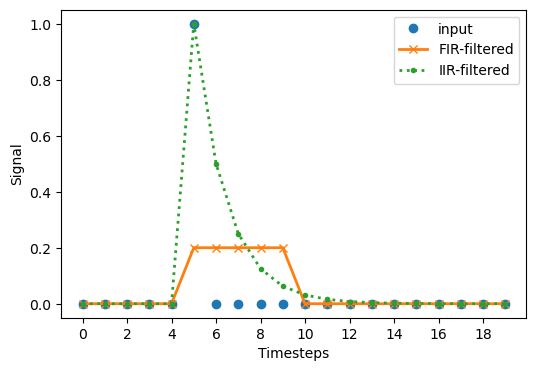

In [2]:
# Generate the impulse and the time-axis
xx = np.zeros(20)
xx[5] = 1
tt = np.arange(20)
data = {}
data["before"] = xx
data["after_fir"] = signal.lfilter(np.ones(5) / 5, 1, xx)
data["after_iir"] = signal.lfilter([1], [1, -0.5], xx)

# Show the results
_, ax = plt.subplots(figsize=(6, 4))
ax.plot(tt, data["before"], "o", label="input", lw=2)
ax.plot(tt, data["after_fir"], "x-", label="FIR-filtered", lw=2)
ax.plot(tt, data["after_iir"], ".:", label="IIR-filtered", lw=2)
ax.set(xlabel="Timesteps", ylabel="Signal", xticks=np.arange(0, 20, 2))
ax.legend()

# plt.savefig("../images/filter-fir-iir.png")
plt.show()

### Morphological Filter

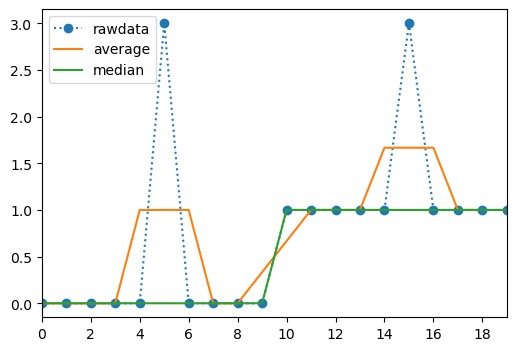

In [3]:
# Create the data
x1 = np.zeros(20)
x1[10:] = 1
# Add some noise-spikes
x1[[5, 15]] = 3
# Median filter the signal
x_med = signal.medfilt(x1, 3)
# Average filtered data
b = np.ones(3) / 3
x_filt = signal.lfilter(b, 1, x1)

# Plot the data
_, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(x1, "o", linestyle="dotted", label="rawdata")
ax1.plot(x_filt[1:], label="average")
ax1.plot(x_med, label="median")
ax1.set(xlim=[0, 19], xticks=np.arange(0, 20, 2))
ax1.legend()
# plt.savefig("../images/filter-morph.png")
plt.show()

## Filter Characteristics

### Impulse- and Step-Response

In [4]:
len_filter = 5
bb = np.ones(len_filter) / len_filter
aa = 1

[Text(0.5, 0, 'n * T')]

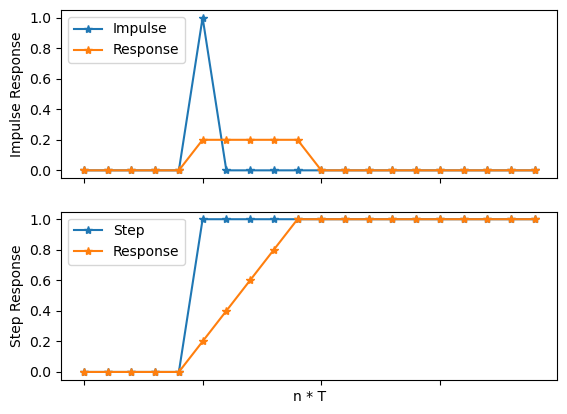

In [5]:
# Define the impulse ...
xImpulse = np.zeros(20)
xImpulse[5] = 1
# Define the step ...
xStep = np.zeros(20)
xStep[5:] = 1

## Generate coefficients for an averaging filter (FIR)
xs = [xImpulse, xStep]
xlabels = ["Impulse", "Step"]
_, axs = plt.subplots(2, 1, sharex=True)

for x_, xlabel, ax_ in zip(xs, xlabels, axs.flatten()):
    # Find the impulse-response
    y_ = signal.lfilter(bb, aa, x_)
    # Plot input and response
    ax_.plot(x_, "*-", label=xlabel)
    ax_.plot(y_, "*-", label="Response")
    ax_.legend(loc="upper left")
    ax_.set(ylabel=f"{xlabel} Response", xticks=np.arange(0, len(x_), 5))
    ax_.tick_params(axis="x", labelbottom=False)

axs[1].set(xlabel="n * T")
# plt.savefig("../images/filter-response.png")

### Frequency Response

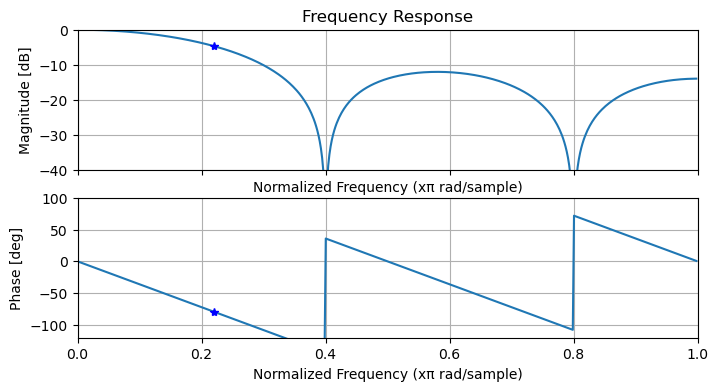

In [6]:
## Frequency Response
w, h = signal.freqz(bb, aa, fs=2)  # Calculate the normalized values
dB = 20 * np.log10(np.abs(h))
phase = np.rad2deg(np.arctan2(h.imag, h.real))
# Plot them, in a new figure
_, axfs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

axfs[0].plot(w, dB)
axfs[0].set(
    xlabel=r"Normalized Frequency (xπ rad/sample)",
    ylabel="Magnitude [dB]",
    title="Frequency Response",
    ylim=[-40, 0],
)
axfs[0].grid(1)
axfs[1].plot(w, phase)
axfs[1].set(
    xlabel=r"Normalized Frequency (xπ rad/sample)",
    ylabel="Phase [deg]",
    ylim=[-120, 100],
    xlim=[0, 1],
)
axfs[1].grid(1)

# Select a frequency point in the normalized response
selFreq_val = 0.22
selFreq_nr = np.argmin(np.abs(w - selFreq_val))
selFreq_w = w[selFreq_nr]  # Value on plot

# Find gain and phase for the selected frequency
selFreq_h = h[selFreq_nr]

# Show it on the plot
seldB = 20 * np.log10(np.abs(selFreq_h))
selPhase = np.rad2deg(np.arctan2(selFreq_h.imag, selFreq_h.real))
axfs[0].plot(selFreq_w, seldB, "b*")
axfs[1].plot(selFreq_w, selPhase, "b*")
# plt.savefig("../images/filter-response-freq.png")
plt.show()

## Moving Average

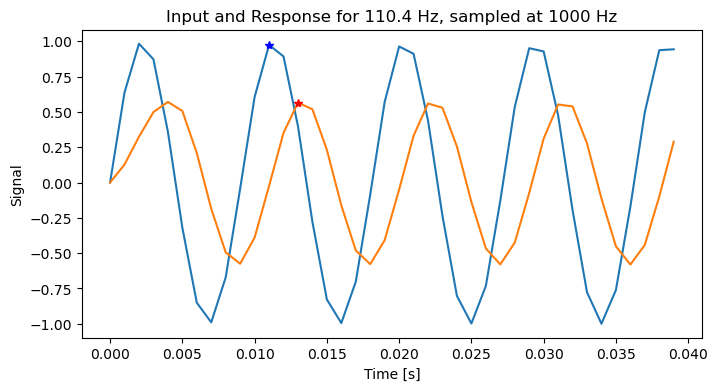

In [7]:
# Convert the normalized frequency to an absolute frequency
rate = 1000
freq = selFreq_w * rate / 2  # Freqency in Hz, for the selected sample rate

# Calculate the input and output sine, for 0.04 sec
t = np.arange(0, 0.04, 1 / rate)
sin_in = np.sin(2 * np.pi * freq * t)
sin_out = signal.lfilter(bb, aa, sin_in)

# Plot them
_, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(t, sin_in, label="Input")
ax2.plot(t, sin_out, label="Output")

ax2.set(
    title=f"Input and Response for {freq:4.1f} Hz, sampled at {rate} Hz",
    xlabel="Time [s]",
    ylabel="Signal",
)

# Estimate gain and phase-shift from the location of the second maximum
# First find the two maxima (input and output)
sndCycle = np.where((t > 1 / freq) & (t < (2 / freq)))[0]

sndMaxIn = np.max(sin_in[sndCycle])
idxSndMaxIn = np.argmax(sin_in[sndCycle])
tMaxIn = t[sndCycle[idxSndMaxIn]]

sndMaxFiltered = np.max(sin_out[sndCycle])
idxSndMaxInFiltered = np.argmax(sin_out[sndCycle])
tMaxOut = t[sndCycle[idxSndMaxInFiltered]]

# Estimate gain and phase-shift from them
gain_est = sndMaxFiltered / sndMaxIn
phase_est = (tMaxIn - tMaxOut) * 360 * freq

# Plot them
ax2.plot(tMaxIn, sndMaxIn, "b*")
ax2.plot(tMaxOut, sndMaxFiltered, "r*")
# plt.savefig("../images/filter-response-nyq.png")
plt.show()

In [8]:
selGain = np.abs(selFreq_h)
print(f"Correct gain and phase: {selGain:4.2f}, and {selPhase:5.1f} deg")
print(f"Numerical estimation: {gain_est:4.2f}, and {phase_est:5.1f} deg")

Correct gain and phase: 0.58, and -79.5 deg
Numerical estimation: 0.58, and -79.5 deg


## Smoothing of Regularly Sampled Data

In [9]:
tempC = io.loadmat("../data/bostemp.mat")
coef_24h = np.ones(24) / 24
zi = signal.lfilter_zi(coef_24h, 1) * 0
avg24hTempC, _ = signal.lfilter(coef_24h, 1, tempC["tempC"].flatten(), zi=zi)
zi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

[Text(0.5, 1.0, 'Logan Airport Dry Bulb Temperature (source: NOAA)'),
 Text(0.5, 0, 'Time elapsed from Jan 1, 2011 (days)'),
 Text(0, 0.5, 'Temp ($ ^∘ $C)')]

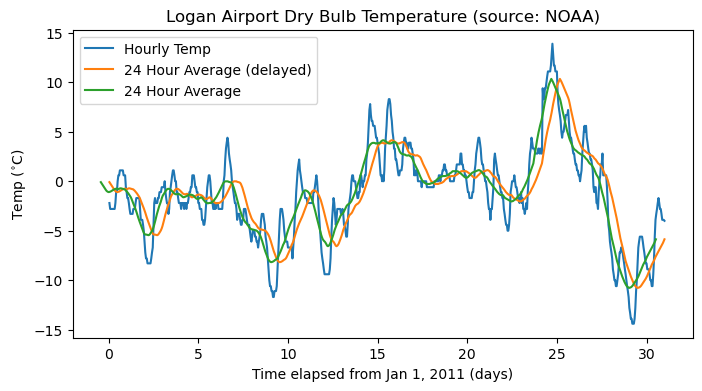

In [10]:
days = (np.arange(31 * 24) + 1) / 24
fDelay = (coef_24h.size - 1) / 2
_, ax_ma = plt.subplots(figsize=(8, 4))
ax_ma.plot(days, tempC["tempC"], label="Hourly Temp")
ax_ma.plot(days, avg24hTempC, label="24 Hour Average (delayed)")
ax_ma.plot(days - fDelay / 24, avg24hTempC, label="24 Hour Average")
ax_ma.legend()
ax_ma.set(
    title="Logan Airport Dry Bulb Temperature (source: NOAA)",
    xlabel="Time elapsed from Jan 1, 2011 (days)",
    ylabel="Temp ($ ^∘ $C)",
)
# plt.savefig("../images/filter-ma.png")

[Text(0.5, 1.0, 'Mean temperature differential from 24 hour average'),
 Text(0.5, 0, 'Hour of day (since midnight)'),
 Text(0, 0.5, 'Temperature difference ($^∘$C)')]

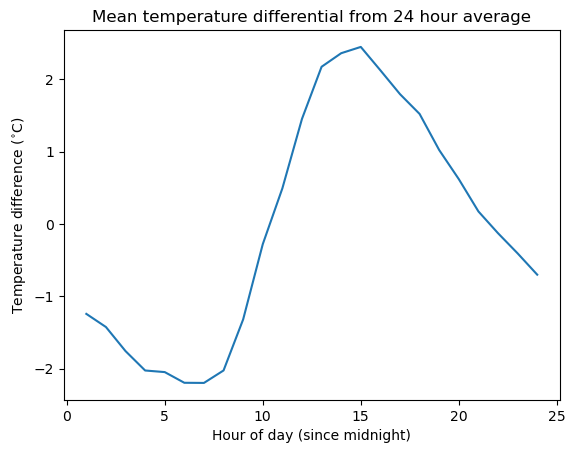

In [11]:
deltaTempC = tempC["tempC"].flatten() - avg24hTempC
_, ax_d = plt.subplots()
ax_d.plot(np.arange(24) + 1, np.mean(deltaTempC.reshape(31, 24), 0))
ax_d.set(
    title="Mean temperature differential from 24 hour average",
    xlabel="Hour of day (since midnight)",
    ylabel="Temperature difference ($^∘$C)",
)

[Text(0.5, 1.0, 'Logan Airport Dry Bulb Temperature (source: NOAA)'),
 Text(0.5, 0, 'Time elapsed from Jan 1, 2011 (days)'),
 Text(0, 0.5, 'Temp ($^∘$C)')]

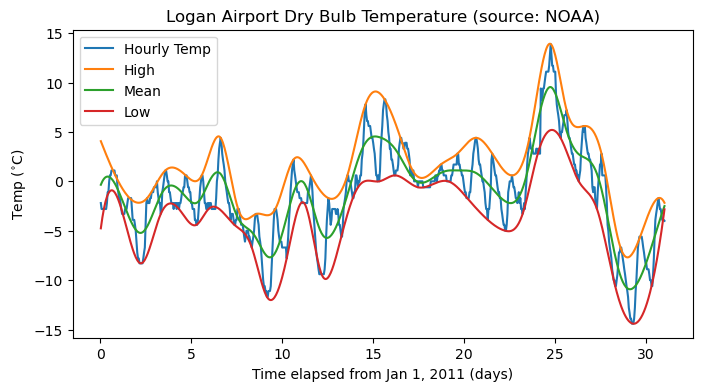

In [12]:
highIdx, _ = signal.find_peaks(tempC["tempC"].flatten(), distance=16)
envHigh = interpolate.UnivariateSpline(
    days[highIdx], tempC["tempC"][highIdx].flatten(), s=0
)
lowIdx, _ = signal.find_peaks(-tempC["tempC"].flatten(), distance=16)
envLow = interpolate.UnivariateSpline(
    days[lowIdx], tempC["tempC"][lowIdx].flatten(), s=0
)
envMean = (envHigh(days) + envLow(days)) / 2

_, ax_p = plt.subplots(figsize=(8, 4))
ax_p.plot(days, tempC["tempC"], label="Hourly Temp")
ax_p.plot(days, envHigh(days), label="High")
ax_p.plot(days, envMean, label="Mean")
ax_p.plot(days, envLow(days), label="Low")
ax_p.legend()
ax_p.set(
    title="Logan Airport Dry Bulb Temperature (source: NOAA)",
    xlabel="Time elapsed from Jan 1, 2011 (days)",
    ylabel="Temp ($^∘$C)",
)
# plt.savefig("../images/filter-peaks.png")

[Text(0.5, 1.0, 'Logan Airport Dry Bulb Temperature (source: NOAA)'),
 Text(0.5, 24.0, 'Time elapsed from Jan 1, 2011 (days)'),
 Text(28.000000000000007, 0.5, 'Temp ($^∘$C)')]

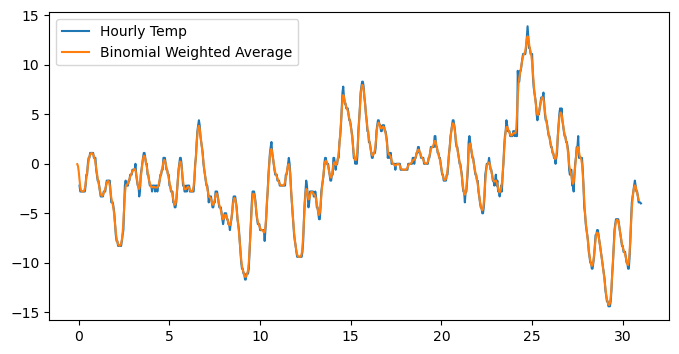

In [13]:
h_b = np.array([1 / 2, 1 / 2])
binomCoef = signal.convolve(h_b, h_b)
for n in range(4):
    binomCoef = signal.convolve(binomCoef, h_b)
zi_b = signal.lfilter_zi(binomCoef, 1) * 0
binomMA, _ = signal.lfilter(binomCoef, 1, tempC["tempC"].flatten(), zi=zi_b)

fDelay_b = (len(binomCoef) - 1) / 2
_, ax_b = plt.subplots(figsize=(8, 4))
ax_b.plot(days, tempC["tempC"], label="Hourly Temp")
ax_b.plot(
    days - fDelay_b / 24,
    binomMA,
    label="Binomial Weighted Average",
)
ax_b.legend()
ax_p.set(
    title="Logan Airport Dry Bulb Temperature (source: NOAA)",
    xlabel="Time elapsed from Jan 1, 2011 (days)",
    ylabel="Temp ($^∘$C)",
)
# plt.savefig("../images/filter-binom.png")

[Text(0.5, 1.0, 'Logan Airport Dry Bulb Temperature (source: NOAA)'),
 Text(0.5, 0, 'Time elapsed from Jan 1, 2011 (days)'),
 Text(0, 0.5, 'Temp ($^∘$C)')]

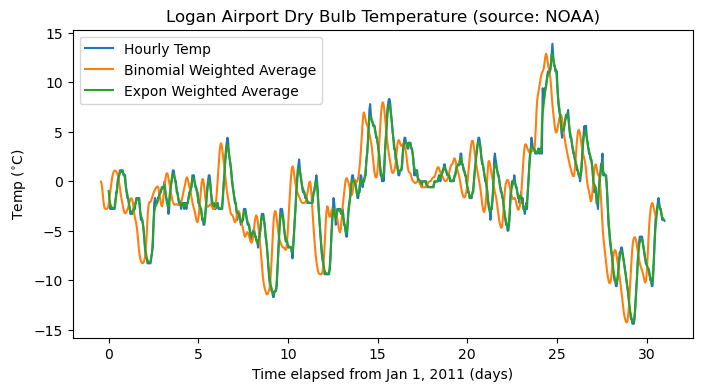

In [14]:
alpha = 0.45
zi_ex = signal.lfilter_zi(np.array([alpha]), np.array([1, alpha - 1])) * 0
exponMA, _ = signal.lfilter(
    np.array([alpha]),
    np.array([1, alpha - 1]),
    tempC["tempC"].flatten(),
    zi=zi_ex,
)
_, ax_ex = plt.subplots(figsize=(8, 4))
ax_ex.plot(days, tempC["tempC"], label="Hourly Temp")
ax_ex.plot(days - fDelay / 24, binomMA, label="Binomial Weighted Average")
ax_ex.plot(days - 1 / 24, exponMA, label="Expon Weighted Average")
ax_ex.legend()
ax_ex.set(
    title="Logan Airport Dry Bulb Temperature (source: NOAA)",
    xlabel="Time elapsed from Jan 1, 2011 (days)",
    ylabel="Temp ($^∘$C)",
)
# plt.savefig("../images/filter-expon.png")

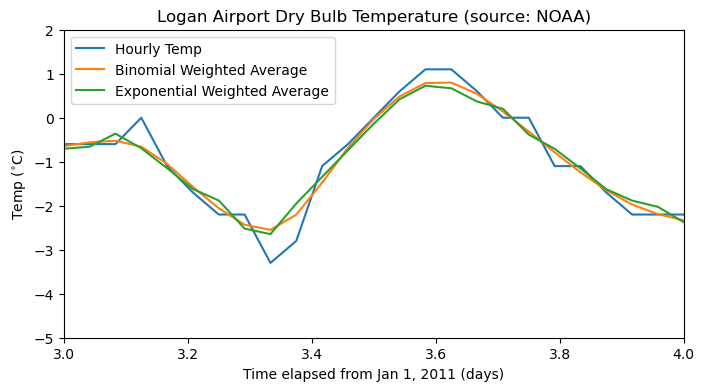

In [15]:
_, ax_ex1 = plt.subplots(figsize=(8, 4))
ax_ex1.plot(days, tempC["tempC"], label="Hourly Temp")
ax_ex1.plot(
    days - fDelay_b / 24,
    binomMA,
    label="Binomial Weighted Average",
)
ax_ex1.plot(days - 1 / 24, exponMA, label="Exponential Weighted Average")
ax_ex1.legend()
ax_ex1.set(
    title="Logan Airport Dry Bulb Temperature (source: NOAA)",
    xlabel="Time elapsed from Jan 1, 2011 (days)",
    ylabel="Temp ($^∘$C)",
    xlim=[3, 4],
    ylim=[-5, 2],
)
plt.show()

### Savitzky-Golay Filter

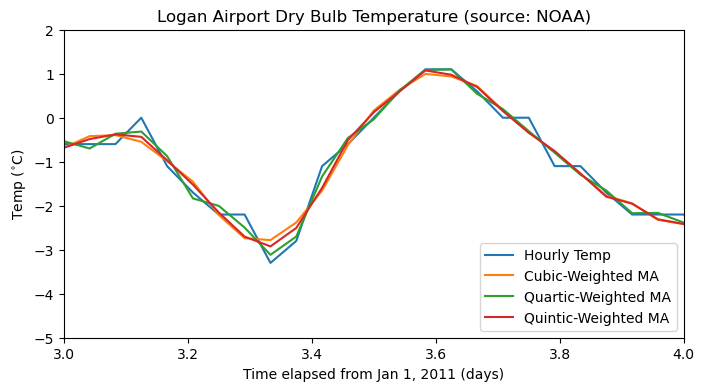

In [16]:
cubicMA = signal.savgol_filter(tempC["tempC"].flatten(), 7, 3)
quarticMA = signal.savgol_filter(tempC["tempC"].flatten(), 7, 4)
quinticMA = signal.savgol_filter(tempC["tempC"].flatten(), 9, 5)

_, ax_sg = plt.subplots(figsize=(8, 4))
ax_sg.plot(days, tempC["tempC"], label="Hourly Temp")
ax_sg.plot(days, cubicMA, label="Cubic-Weighted MA")
ax_sg.plot(days, quarticMA, label="Quartic-Weighted MA")
ax_sg.plot(days, quinticMA, label="Quintic-Weighted MA")
ax_sg.legend()
ax_sg.set(
    title="Logan Airport Dry Bulb Temperature (source: NOAA)",
    xlabel="Time elapsed from Jan 1, 2011 (days)",
    ylabel="Temp ($^∘$C)",
    xlim=[3, 4],
    ylim=[-5, 2],
)
# plt.savefig("../images/filer-savgol.png")
plt.show()

### Integration

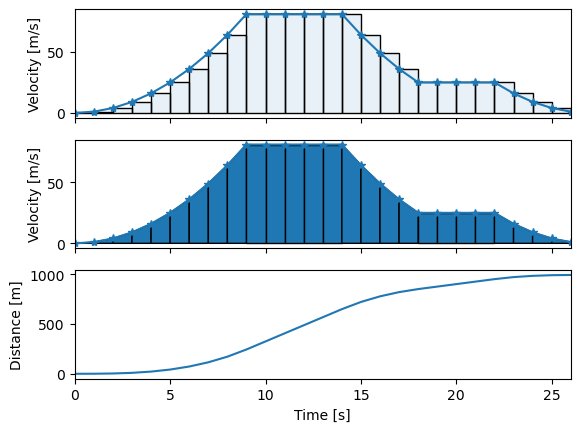

In [17]:
# Generate velocity data
vel = np.hstack((
    np.arange(10) ** 2,
    np.ones(4) * 9**2,
    np.arange(9, 4, -1) ** 2,
    np.ones(3) * 5**2,
    np.arange(5, 0, -1) ** 2,
))
time = np.arange(len(vel))

## Plot the data
fig, axs2 = plt.subplots(3, 1, sharex=True)

axs2[0].plot(time, vel, "*-")
for ii in range(len(vel) - 1):
    ## Corresponding trapezoid corners
    x = [time[ii], time[ii], time[ii + 1], time[ii + 1]]
    y = [0, vel[ii], vel[ii], 0]
    data_stack = np.column_stack((x, y))
    axs2[0].add_patch(patches.Polygon(data_stack, alpha=0.1))
    axs2[0].add_patch(patches.Polygon(data_stack, fill=False))
axs2[0].set(ylabel="Velocity [m/s]")

axs2[1].plot(time, vel, "*-")
for ii in range(len(vel) - 1):
    ## Corresponding trapezoid corners
    x = [time[ii], time[ii], time[ii + 1], time[ii + 1]]
    y = [0, vel[ii], vel[ii + 1], 0]
    data_stack2 = np.column_stack((x, y))
    axs2[1].add_patch(patches.Polygon(data_stack2))
    axs2[1].add_patch(patches.Polygon(data_stack2, fill=False))
axs2[1].set(ylabel="Velocity [m/s]")

axs2[2].plot(time, np.hstack([0, integrate.cumulative_trapezoid(vel)]))
axs2[2].set(xlabel="Time [s]", ylabel="Distance [m]", xlim=[0, len(vel) - 1])

# Save and show the image
# plt.savefig("../images/filter-integ.jpg")
plt.show()

## Smoothing of Irregularly Sampled Data

### Lowess and Loess Smoothing

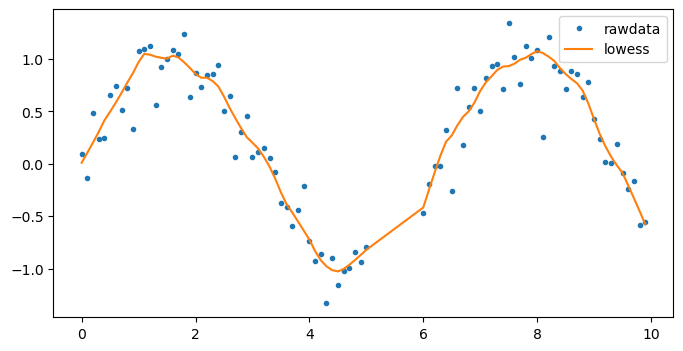

In [18]:
np.random.seed(1234)

# Generate some data
x_sm = np.arange(0, 10, 0.1)
y_sm = np.sin(x_sm) + 0.2 * np.random.randn(len(x_sm))

# Eliminate some, so that we don't have equal sampling distances
cur_ind = np.where((x_sm > 5) & (x_sm < 6))
x_space = np.delete(x_sm, cur_ind)
y_space = np.delete(y_sm, cur_ind)

# Smooth the data with Lowess, from the package "statsmodels"
smoothed = lowess(y_space, x_space, frac=0.1)
idx_low, data_low = smoothed.T

_, ax3 = plt.subplots(figsize=(8, 4))
ax3.plot(x_space, y_space, ".", label="rawdata")
ax3.plot(idx_low, data_low, label="lowess")
ax3.legend()

### Splines

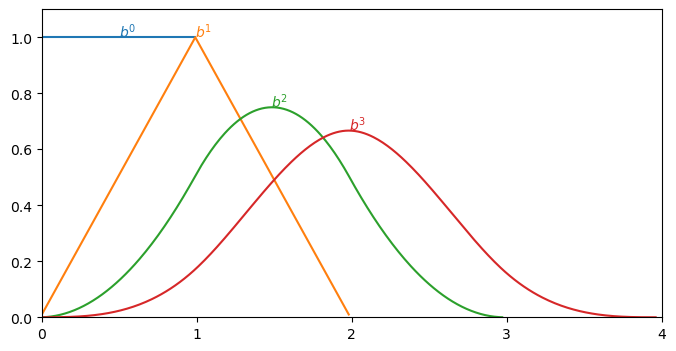

In [ ]:
dt_sp = 0.01  # step interval for plotting
t_sp = np.arange(0, 1, dt_sp)

# Generate the B-splines, through convolution
ones = np.ones(len(t_sp))
Bsplines = [ones]
for _ in range(3):
    Bsplines.append(np.convolve(Bsplines[-1], ones))
    # Normalize the integral to "1"
    Bsplines[-1] /= np.sum(Bsplines[-1]) * dt_sp

# Plot the Bsplines
_, ax_sp = plt.subplots(figsize=(8, 4))
for spline in Bsplines:
    ax_sp.plot(np.arange(len(spline)) * dt_sp, spline)

# Put on labels
ax_sp.text(0.5, 1, "$b^0$", color="C0")
for i_sp in range(1, 4):
    spline = Bsplines[i_sp]
    loc_max = np.argmax(spline) * dt_sp
    val_max = np.max(spline)
    txt = f"$b^{i_sp}$"
    color = f"C{i_sp}"
    ax_sp.text(loc_max, val_max, txt, color=color)

# Format the plot
ax_sp.set(xlim=(0, 4), ylim=(0, 1.1), xticks=(np.arange(5)))
# plt.savefig("../images/filter-spline-b.png")

plt.show()

In [20]:
def scipy_bspline(
    cv, n: int = 100, degree: int = 3, periodic: bool = False
) -> np.ndarray:
    """Calculate n samples on a bspline

    Parameters
    ----------
    cv :  Array of control vertices
    n  :  Number of samples to return
    degree :  Curve degree
    periodic : True - Curve is closed

    Returns
    -------
    spline_data : x/y-values of the spline-curve
    """

    cv = np.asarray(cv)
    count = cv.shape[0]

    # Closed curve
    if periodic:
        kv = np.arange(-degree, count + degree + 1)
        factor, fraction = divmod(count + degree + 1, count)
        cv = np.roll(np.concatenate((cv,) * factor + (cv[:fraction],)), -1, axis=0)
        degree = np.clip(degree, 1, degree)

    # Opened curve
    else:
        degree = np.clip(degree, 1, count - 1)
        kv = np.clip(np.arange(count + degree + 1) - degree, 0, count - degree)

    # Return samples
    max_param = count - (degree * (1 - periodic))
    spl = interpolate.BSpline(kv, cv, degree)
    spline_data = spl(np.linspace(0, max_param, n))

    return spline_data

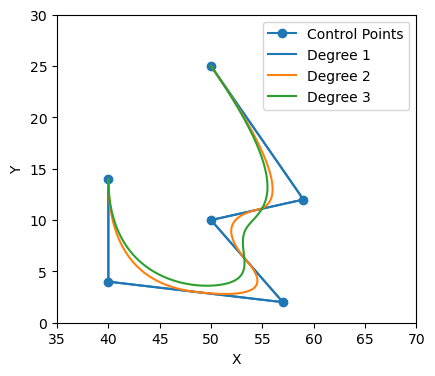

In [21]:
cv = np.array([
    [50.0, 25.0],
    [59.0, 12.0],
    [50.0, 10.0],
    [57.0, 2.0],
    [40.0, 4.0],
    [40.0, 14.0],
])

_, ax_sp2 = plt.subplots(figsize=(8, 4))
ax_sp2.plot(cv[:, 0], cv[:, 1], "o-", label="Control Points")

ax_sp2.set_prop_cycle(None)

# for degree in range(1,7):
for degree in [1, 2, 3]:
    p = scipy_bspline(cv, n=100, degree=degree, periodic=False)
    x_sp, y_sp = p.T
    ax_sp2.plot(x_sp, y_sp, label=f"Degree {degree}")

# Format the plot
ax_sp2.legend()
ax_sp2.set(xlabel=("X"), ylabel=("Y"), xlim=(35, 70), ylim=(0, 30))
ax_sp2.set_aspect("equal", adjustable="box")
plt.show()

### Kernel Density Estimation

In [22]:
def plot_histogram(ax, data):
    """Left plot: histogram"""

    ax.hist(data, bins=6, range=[-4, 8], density=True, ec="k", fc="#AFDBFF")
    ax.set(xlim=(-6, 11), ylim=(-0.005, 0.18), ylabel=("Density"))
    # Add rugplot
    for ii in range(len(data)):
        ax.plot([data, data], [0, -0.005], "b")


def plot_normdist(ax, pos, sd, xcum, ycum):
    """Plot individual curves"""

    x = np.arange(pos - 3 * sd, pos + 3 * sd, 0.1)
    nd = stats.norm(pos, sd)
    y = nd.pdf(x)
    ax.plot(x, y / 10, "r--", lw=0.5)

    # Cumulative curve
    xcr = np.round(xcum * 10)
    xir = np.round(x * 10)
    for ii in range(len(xir)):
        ycum[xcr == xir[ii]] += y[ii]
    return ycum


def explain_KDE(ax, data):
    """Right plot: Explanation of KDE"""

    # Prepare cumulative arrays
    xcum = np.arange(-6, 11, 0.1)
    ycum = np.zeros_like(xcum)

    # Width of the individual Gaussian
    var = 2.25
    sd = np.sqrt(var)

    # Plot individual Gaussian
    ax.set(xlim=(-6, 11), ylim=(-0.005, 0.18))
    ax.axhline(0)

    # Rugplot & individual Gaussian
    for ii in range(len(data)):
        ax.plot([data, data], [0, -0.005], "b")
        ycum = plot_normdist(ax, data[ii], sd, xcum, ycum)

    # Plot cumulative curve
    ycum /= np.sum(ycum) / 10
    ax.plot(xcum, ycum)

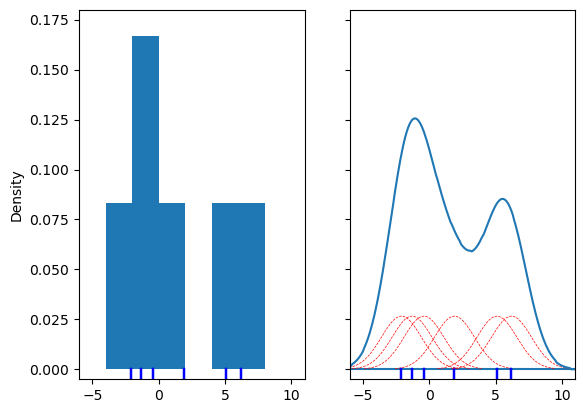

In [23]:
# Generate dummy data
x_k = np.array([-2.1, -1.3, -0.4, 1.9, 5.1, 6.2])

# Define the two plots
_, ax_k = plt.subplots(1, 2, sharey=True)

# Generate the left plot
plot_histogram(ax_k[0], x_k)

# Generate the right plot
explain_KDE(ax_k[1], x_k)
# plt.savefig("../images/filter-kde.png")
plt.show()

## Filtering Images

### Astronaut

In [24]:
img = plt.imread("../data/astronaut.png")
img.shape

(512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


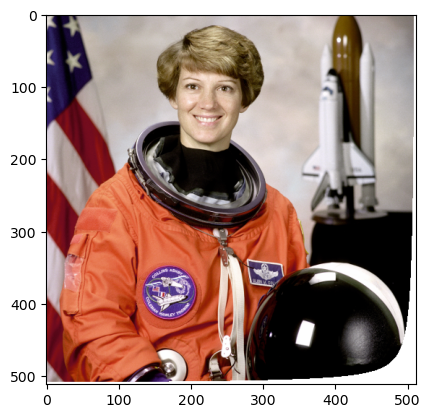

In [25]:
# Get a color-image
nrows, ncols = img.shape[:2]

# Make vectors from 1 to 0, with lengths matching the image
alpha_row = np.linspace(1, 0, ncols)
alpha_col = np.linspace(1, 0, nrows)

# Make coordinate-grids
X, Y = np.meshgrid(alpha_row, alpha_col)

# Scale the vector from 0 to 255, and
# let the image fade from top-right to bottom-left
X_Y = np.uint8(X * Y * 255)
X_Y = np.atleast_3d(X_Y)  # make sure the dimensions matches the image

# Add the alpha-layer
img_alpha = np.concatenate((img, X_Y), axis=2)

plt.imshow(img_alpha)

### Camera man

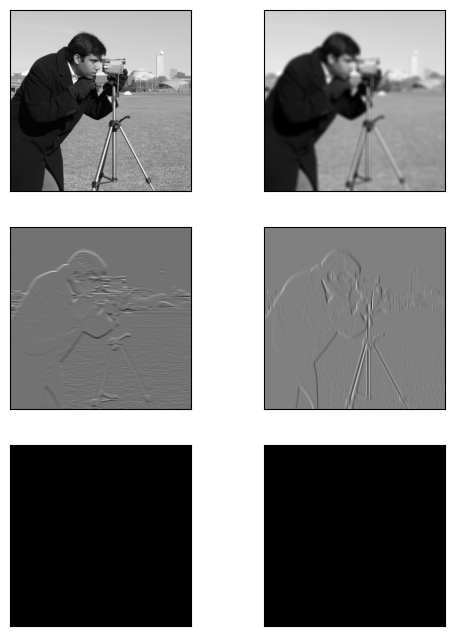

In [26]:
cam = plt.imread("../data/camera.png")

# for the filtering, the data must not be uint
img_f = np.array(cam, dtype=float)

# Make the filters
Filters = []
Filters.append(np.ones((11, 11)) / 121)
Filters.append(np.array([np.ones(11), np.zeros(11), -1 * np.ones(11)]))
Filters.append(Filters[-1].T)

# Filter the images
filtered = []
for filt in Filters:
    filtered.append(ndimage.correlate(img_f, filt))

# Make the plots
_, ax_is = plt.subplots(3, 2, figsize=(6, 8))
plt.gray()

ax_is[0, 0].imshow(cam)
ax_is[0, 1].imshow(filtered[0])
ax_is[1, 0].imshow(filtered[1])
ax_is[1, 1].imshow(filtered[2])
ax_is[2, 0].imshow(filtered[1] > 125)
ax_is[2, 1].imshow(filtered[2] > 125)

# Remove the ticks and labels
for axis in ax_is.flatten():
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)

# Reduce the space between the plots
plt.show()